# Waste Water
Tracking viral load in waste water is leading indicator of coming Covid cases. New Orleans has been slow to start waste water testing, but there is now enough days of data for some analysis.

In [1]:
#import necessary modules
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#get data
url = 'https://data.cdc.gov/resource/2ew6-ywp6.json?county_names=Orleans'
data = requests.get(url)
df = pd.read_json(data.content)
df.head()

,wwtp_jurisdiction,wwtp_id,reporting_jurisdiction,sample_location,key_plot_id,county_names,county_fips,population_served,date_start,date_end,ptc_15d,detect_prop_15d
0,Louisiana,727,Louisiana,Treatment plant,CDC_la_727_Treatment plant_raw wastewater,Orleans,22071,380000,2022-02-11,2022-02-25,-89.0,100.0
1,Louisiana,727,Louisiana,Treatment plant,CDC_la_727_Treatment plant_raw wastewater,Orleans,22071,380000,2022-02-08,2022-02-22,-91.0,100.0
2,Louisiana,792,Louisiana,Treatment plant,CDC_la_792_Treatment plant_raw wastewater,Orleans,22071,380000,2022-03-03,2022-03-17,-87.0,60.0
3,Louisiana,792,Louisiana,Treatment plant,CDC_la_792_Treatment plant_raw wastewater,Orleans,22071,380000,2022-01-28,2022-02-11,NaN,NaN
4,Louisiana,727,Louisiana,Treatment plant,CDC_la_727_Treatment plant_raw wastewater,Orleans,22071,380000,2022-02-04,2022-02-18,NaN,100.0


In [3]:
#get earliest day
df = df[['wwtp_id', 'county_names',  'date_start', 'date_end', 'ptc_15d']]
df = df[~df.ptc_15d.isna()]
df.date_start = pd.to_datetime(df.date_start, format='%Y-%m-%d')
df.date_end = pd.to_datetime(df.date_end, format='%Y-%m-%d')
df.sort_values('date_end', inplace=True, axis=0)
df.reset_index(inplace=True, drop=True)
plants = list(set(df.wwtp_id.tolist()))

start_dates = df.date_start.tolist()
first_day = str(np.array(start_dates).min()).split(' ')[0]
first_day

'2022-02-08'

In [4]:
#create dictionary of plants
plant_dict = {}
for plant in plants:
    plant_dict[plant] = df[df.wwtp_id == plant]

/var/folders/68/5_5c_xhj2pd0pgs6t9bkvkxm0000gn/T/ipykernel_40112/3858512133.py:33: RuntimeWarning: divide by zero encountered in double_scalars
  start_amt = base/(1+(change_factor/100))


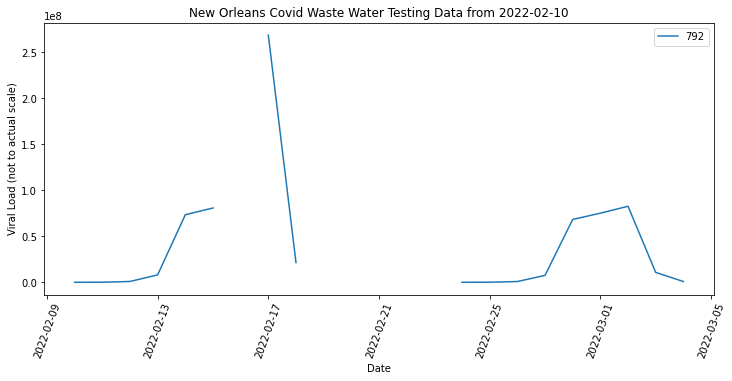

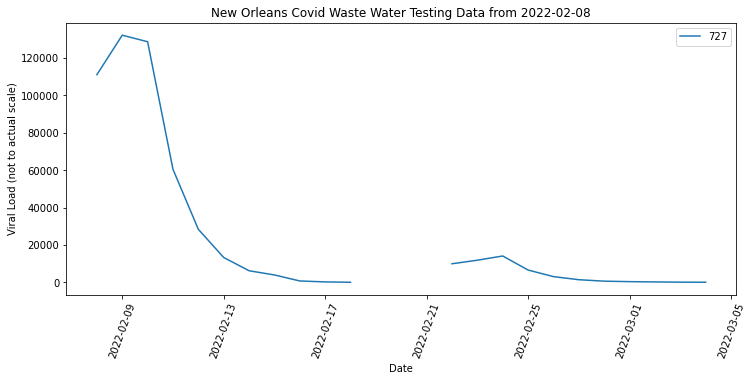

In [5]:
# for each plant, analyze data and produce a graph
for plant in plant_dict:
    df = plant_dict.get(plant)
    df.reset_index(drop=True, inplace=True)
    # see if there's enough data
    end_dates = df.date_end.tolist()
    start_dates = df.date_start.tolist()
    first_day = str(np.array(start_dates).min()).split(' ')[0]
    enough = False
    for dat in end_dates:
        if dat in start_dates:
            enough = True

    # calculate quantity for first end date forward as start
    idx_first = df[df.date_start == df.date_end.min()].index[0]
    for i in range(idx_first, df.index.max()+1, 1):
        if i == idx_first:
            df.loc[i, 'start_quantity'] = 10000
        else:
            base = df.loc[i-1, 'start_quantity']
            percent_change = df.loc[i, 'ptc_15d']
            if percent_change == 100:
                percent_change = 99
            delta = df.loc[i, 'ptc_15d']/100*base
            new_total = base+delta
            df.loc[i, 'start_quantity'] = int(new_total)

    # infer old values
    to_calculate = df[~df.start_quantity.isna()].date_start.tolist()
    for dat in to_calculate:
        calc_idx = df[df.date_end == dat].index[0]
        base_idx = df[df.date_start == dat].index[0]
        change_factor = df.loc[calc_idx, 'ptc_15d']
        base = df.loc[base_idx, 'start_quantity']
        start_amt = base/(1+(change_factor/100))
        df.loc[calc_idx, 'start_quantity'] = start_amt
    
    # create figure
    fig = plt.figure(figsize=(12, 5))
    X = df.date_start.tolist()
    Y = df.start_quantity.tolist()
    plt.plot(X, Y,label=plant)
    plt.title(f'New Orleans Covid Waste Water Testing Data from {first_day}')
    plt.xlabel('Date')
    plt.ylabel('Viral Load (not to actual scale)')
    plt.legend()
    plt.xticks(rotation=70)
